In [1]:
from google.colab.drive import mount
mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/data.zip

Archive:  /content/drive/MyDrive/data.zip
   creating: data/
  inflating: __MACOSX/._data         
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/CameraSeg/
   creating: data/CameraRGB/
  inflating: data/CameraSeg/F65-13.png  
  inflating: data/CameraSeg/F62-32.png  
  inflating: data/CameraSeg/F62-26.png  
  inflating: data/CameraSeg/F68-84.png  
  inflating: data/CameraSeg/F68-90.png  
  inflating: data/CameraSeg/F66-95.png  
  inflating: data/CameraSeg/F61-88.png  
  inflating: data/CameraSeg/F66-81.png  
  inflating: data/CameraSeg/F68-47.png  
  inflating: data/CameraSeg/F61-63.png  
  inflating: data/CameraSeg/F61-77.png  
  inflating: data/CameraSeg/F68-53.png  
  inflating: data/CameraSeg/F66-56.png  
  inflating: data/CameraSeg/F66-42.png  
  inflating: data/CameraSeg/F63-99.png  
  inflating: data/CameraSeg/F64-90.png  
  inflating: data/CameraSeg/F64-84.png  
  inflating: data/CameraSeg/F63-66.png  
  inflating: data/CameraSe

In [3]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose,concatenate

# from test_utils import summary, comparator

In [4]:
import os
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraSeg/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path + i for i in image_list]
mask_list = [mask_path + i for i in mask_list]

Array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12], dtype=uint8)

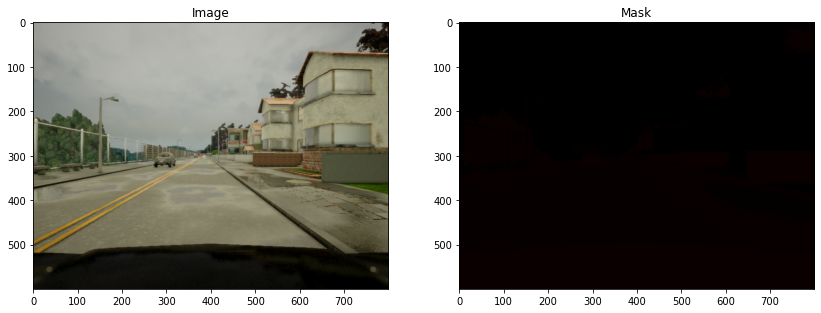

In [5]:
N = 200
img = imageio.imread(image_list[N])
# img = (img - img.min()) / (img.max() - img.min())
mask = imageio.imread(mask_list[N])
# mask = (mask - mask.min()) / (mask.max() - mask.min())
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Mask')
np.unique(mask)

In [6]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)


In [7]:
for path in zip(image_list_ds.take(4), mask_list_ds.take(4)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/F61-1.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraSeg/F61-1.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/F61-10.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraSeg/F61-10.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/F61-100.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraSeg/F61-100.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/F61-11.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraSeg/F61-11.png'>)


In [8]:
image_filenames = tf.constant(image_list)
mask_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, mask_filenames))
for image, mask in dataset.take(4):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/F62-98.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraSeg/F62-98.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraRGB/F61-74.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraSeg/F61-74.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraRGB/F68-78.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraSeg/F68-78.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraRGB/F63-64.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraSeg/F63-64.png', shape=(), dtype=string)


In [9]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
        
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')
    
    input_image =input_image / 255.
    
    return input_image, input_mask

In [10]:
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

(600, 800, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


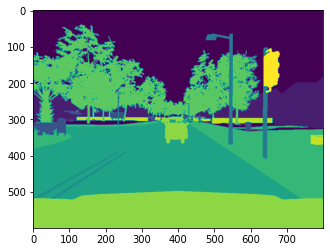

In [24]:
for img, msk in image_ds.take(1):
    print(msk.shape)
    print(np.unique(msk))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(msk))

In [12]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)     
    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
                                
    if dropout_prob>0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(2, strides=2)(conv)
        
    else:
        next_layer = conv
            
    skip_connection = conv
    
    return next_layer, skip_connection


In [13]:
input_size = (96, 128, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)


In [14]:
def upsampling_block(expansive_input, contractive_input, n_filters):
    
    up = Conv2DTranspose(n_filters,
                        3,
                        strides=2,
                        padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    return conv

In [15]:
input_size1=(12, 16, 256)
input_size2 = (24, 32, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)


In [16]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=13):
    inputs = Input(input_size)
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8, dropout_prob=0.3)
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16, dropout_prob=0.3, 
                         max_pooling=False)
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)
    
    conv9 = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(ublock9)
    conv10 = Conv2D(n_classes,1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model
                

In [17]:
image_height = 96
image_width = 128
num_channels = 3

unet = unet_model((image_height, image_width, num_channels))

In [18]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 96, 128, 32)  896         ['input_4[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d_4[0][0]']               
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_5[0][0]']         

In [19]:
unet.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

In [20]:
def display(display_list):
    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show

(600, 800, 1)


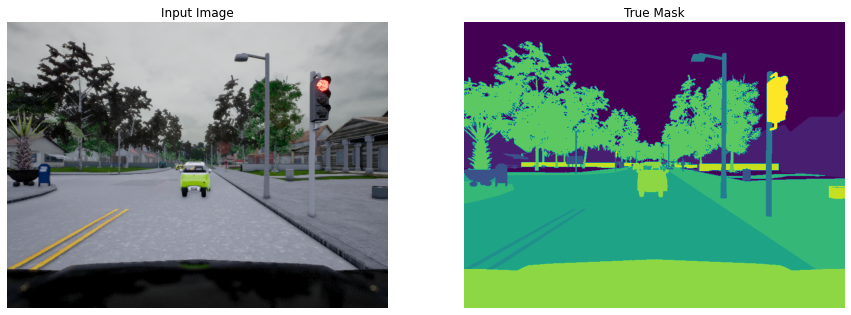

In [21]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


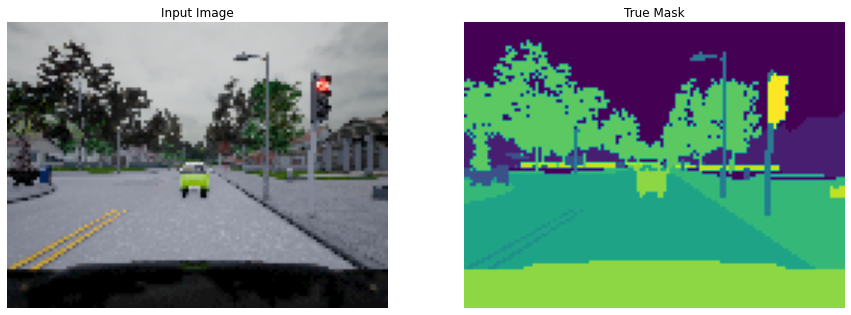

In [22]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [25]:
EPOCHS=40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
32/32 [==============================] - 37s 425ms/step - loss: 2.1351 - accuracy: 0.3073
Epoch 2/40
32/32 [==============================] - 4s 134ms/step - loss: 1.3150 - accuracy: 0.5242
Epoch 3/40
32/32 [==============================] - 4s 134ms/step - loss: 0.8878 - accuracy: 0.7042
Epoch 4/40
32/32 [==============================] - 4s 135ms/step - loss: 0.7104 - accuracy: 0.7574
Epoch 5/40
32/32 [==============================] - 4s 136ms/step - loss: 0.5432 - accuracy: 0.8119
Epoch 6/40
32/32 [==============================] - 4s 137ms/step - loss: 0.5003 - accuracy: 0.8297
Epoch 7/40
32/32 [==============================] - 4s 138ms/step - loss: 0.4500 - accuracy: 0.8537
Epoch 8/40
32/32 [==============================] - 4s 138ms/step - loss: 0.4110 - accuracy: 0.8675
Epoch 9/40
32/32 [==============================] - 4s 139ms/step - loss: 0.37

In [46]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

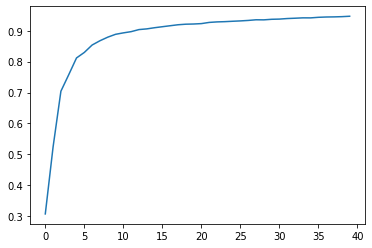

In [47]:
plt.plot(model_history.history["accuracy"])

In [70]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet.predict(image)
      print(pred_mask.shape)
      pred_mask = tf.argmax(pred_mask, axis=-1)
      print(pred_mask.shape)
      pred_mask = pred_mask[..., tf.newaxis]
      print(pred_mask.shape)
      display([image[0], mask[0], pred_mask[0]])
      print(image[0].shape)
      print(mask[0].shape)
      # print(create_mask(pred_mask).shape)
      print(pred_mask[0].shape)

(32, 96, 128, 13)
(32, 96, 128)
(32, 96, 128, 1)
(96, 128, 3)
(96, 128, 1)
(96, 128, 1)


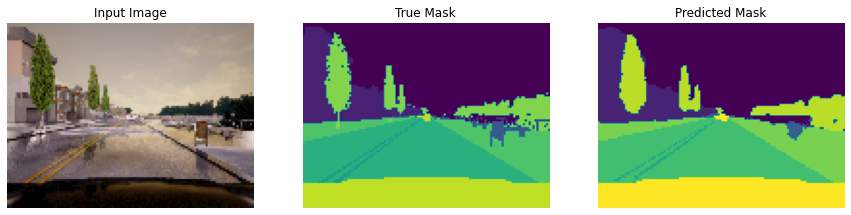

In [71]:
show_predictions(train_dataset, 1)